In [ ]:
import imageio
from skimage import io, color
import matplotlib.pyplot as plt
import numpy as np
import cv2

import warnings
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

In [ ]:
def load_image_as_array():
  img = io.imread("image.jpg")
  img = cv2.resize(img, (512,512))
  img_to_array = np.array(img, dtype=np.int)
  img_arr = img_to_array[:, :, 0] 
  return img_arr, img

In [ ]:
def show_hist(img,img_arr):
  plt.title("Histogram of the Image")
  plt.xlabel("gray scale")
  plt.ylabel("pixels")
  _ = plt.hist(img_arr,histtype='step')

In [ ]:
def uni_quantize_func(img_arr, b):
  phi_low=img_arr.min()
  phi_high=img_arr.max()
  delta = (phi_high - phi_low)/(2**b)
  quantized = phi_low + (np.floor((img_arr - phi_low)/delta)+0.5)*delta
  return quantized

In [ ]:
def calc_uni_mse(img_arr):
  mse_errors = []
  for i in range(1,9):
    mse_errors.append(np.mean((img_arr - uni_quantize_func(img_arr, i))**2))
  plt.plot(range(1,9), mse_errors)
  plt.title("MSE as a function of b bits")
  plt.xlabel("b")
  _ = plt.ylabel("MSE")
  return mse_errors

In [ ]:
def uniform_desicion_rep(img_arr, b):
  #we'll use the formula we saw in class
  phi_low=img_arr.min()
  phi_high=img_arr.max()
  delta = (phi_high - phi_low)/(2**b)
  decision_levels=[]
  representation_levels=[]
  for i in range(0, 2**b+1) :
    decision_levels.append(phi_low + delta*i)
  for i in range(0, 2**b) :
    representation_levels.append(phi_low + (i+0.5)*delta)
  return decision_levels, representation_levels

In [ ]:
def print_uni_rep_des(img_arr):
  for i in range(1,9):
    decision_levels , _ = uniform_desicion_rep(img_arr, i)
    plt.plot(range(0,2**i+1), decision_levels, "o", color="orange")
    plt.title("decision levels with " +str(i)+ " bits")
    plt.xlabel("index")
    plt.ylabel("value")
    plt.show()
  for i in range(1,9):
    _, representation_levels=uniform_desicion_rep(img_arr, i)
    plt.plot(range(1,2**i+1), representation_levels, "o",color="green")
    plt.title("representation levels with " +str(i)+ " bits")
    plt.xlabel("index")
    plt.ylabel("value")
    _ = plt.show()

In [ ]:
def calc_representation(hist, decision_levels):
  #according to the formula we saw in class, we'll calculate first the numerator
  numerator_integral=[]
  for p in range(hist.size):
    numerator_integral.append(p*hist[p])
  #and not use it to calculate the rest of the formula
  representation_levels = np.zeros(np.array(decision_levels).size-1)
  for i in range(0,representation_levels.size):
    #integrate=summation
    temp1=np.sum(hist[int(decision_levels[i]):int(decision_levels[i+1])])
    temp2=np.sum(numerator_integral[int(decision_levels[i]):int(decision_levels[i+1])])
    if(temp1==0 or temp2==0):
      representation_levels[i]=(int(decision_levels[i]+decision_levels[i+1]))/2
    else:
      representation_levels[i]=temp2/temp1
  return representation_levels

In [ ]:
def calc_decision(representation_levels, decision_levels):
  #according to the formula we saw in class
  for i in range(1,np.array(decision_levels).size-1):
    decision_levels[i] = (representation_levels[i-1]+representation_levels[i])/2
  return decision_levels

In [ ]:
def calc_mse(hist, representation_levels, len):
  #according to the formula we saw in class
  mse=0
  for i in range(hist.size):
    rep_diff=((representation_levels-i)**2).min()
    mse+=hist[i]*rep_diff
  mse/=len
  return mse

In [ ]:
def maxloyd(hist, decision_levels, epsilon):
  decision_levels_new=decision_levels
  len=np.sum(hist)
  representation_levels=calc_representation(hist,decision_levels_new)
  curr_mse=calc_mse(hist, representation_levels, len)
  while True:
    decision_levels_new=calc_decision(representation_levels, decision_levels_new)
    representation_levels=calc_representation(hist,decision_levels_new)
    mse=calc_mse(hist, representation_levels, len)
    if(np.abs(mse-curr_mse)<epsilon):
      return decision_levels_new, representation_levels, mse
    curr_mse=mse

In [ ]:
def calc_max_loyd_mse(img,img_arr,epsilon):
  max_loyd_mse = []
  hist = np.histogram(img, bins= range(0,256)) 
  for i in range(1,9):
    #for each b value, calculate the mse we get from maxloyd
    decision, representation = uniform_desicion_rep(img_arr,i)
    decision, representation, mse = maxloyd(hist[0], decision, epsilon)
    max_loyd_mse.append(mse)
  plt.plot(range(1,9), max_loyd_mse)
  plt.title("MSE as a function of b bits")
  plt.xlabel("b")
  _ = plt.ylabel("MSE")
  return max_loyd_mse

In [ ]:
def print_maxloyd_rep_des(img,img_arr,epsilon):
  for i in range(1,9):
    decision, representation = uniform_desicion_rep(img_arr,i)
    decision, representation, mse = maxloyd(hist[0], decision, epsilon) 
    plt.plot(range(0,2**i+1), decision, "o", color="orange")
    plt.title("decision levels with " +str(i)+ " bits" )
    plt.xlabel("index")
    plt.ylabel("value")
    plt.show()

  for i in range(1,9):
    decision, representation = uniform_desicion_rep(img_arr,i)
    decision, representation, mse = maxloyd(hist[0], decision, epsilon) 
    plt.plot(range(1,2**i+1), representation, "o", color="green")
    plt.title("representation levels with " +str(i)+ " bits")
    plt.xlabel("index")
    plt.ylabel("value")
    _ = plt.show()

In [ ]:
def print_mse_funcs(max_loyd_mse,mse_errors):
  plt1, = plt.plot(range(1,9), mse_errors, label = 'uniform')
  plt2, = plt.plot(range(1,9), max_loyd_mse, label = 'max-loyd')
  
  plt.title("MSE as a function of b bits")
  plt.xlabel("b")
  _ = plt.ylabel("MSE")
  plt.legend(handles = [plt1, plt2])
  plt.show()

Part 1 Quantization

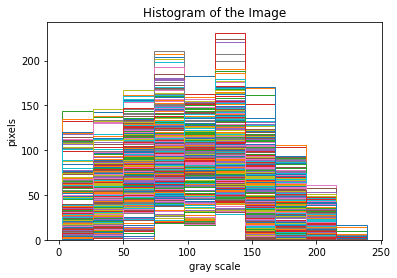

In [ ]:
#Question 1:

img_arr, img = load_image_as_array()
hist = np.histogram(img, bins= range(0,256)) 
show_hist(img,img_arr)

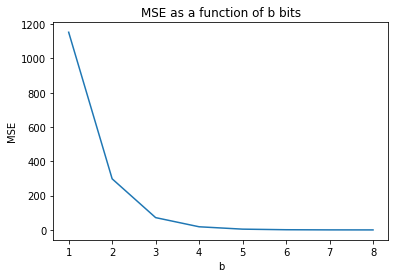

In [ ]:
#Question 2,a:
uni_mse = calc_uni_mse(img_arr)

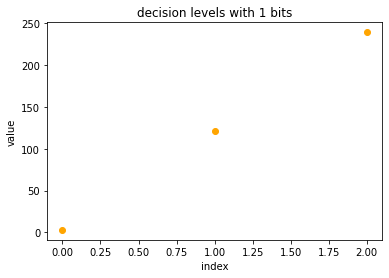

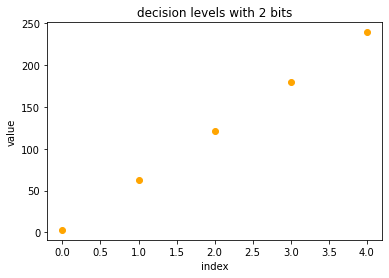

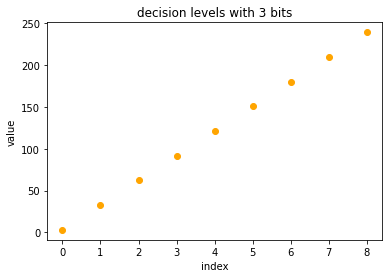

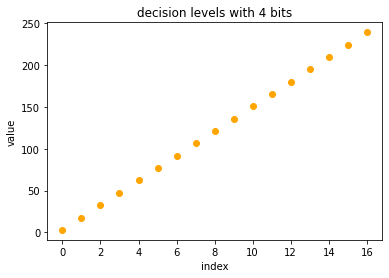

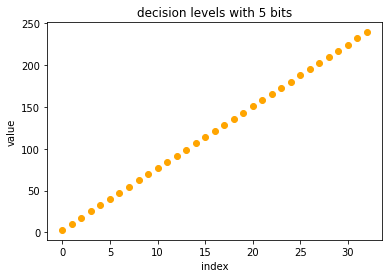

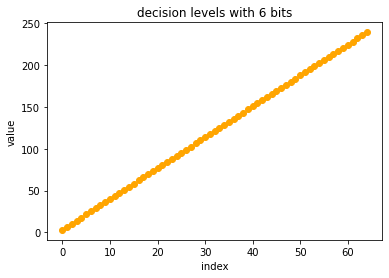

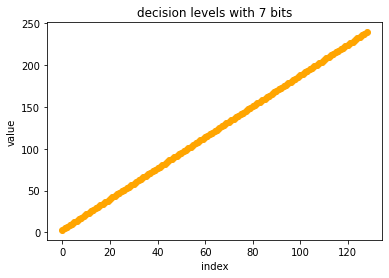

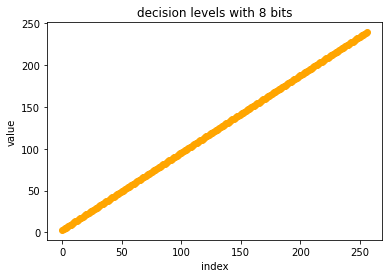

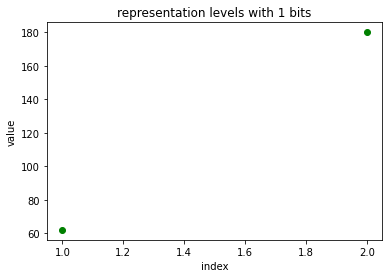

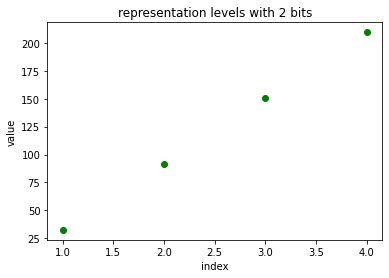

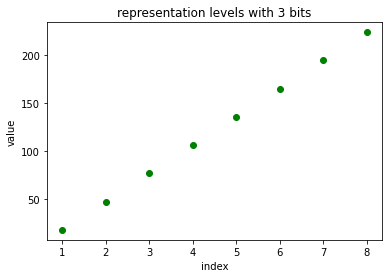

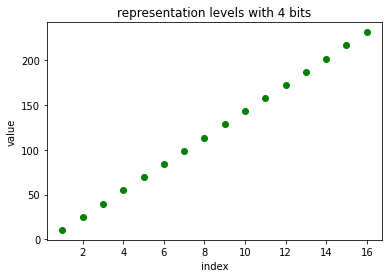

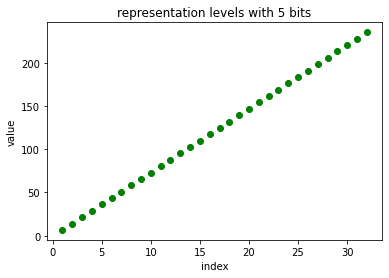

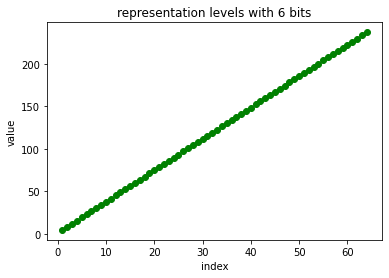

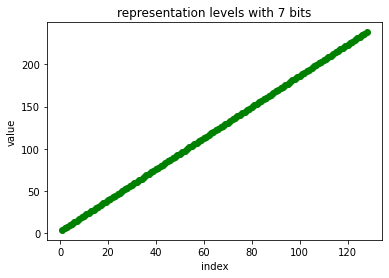

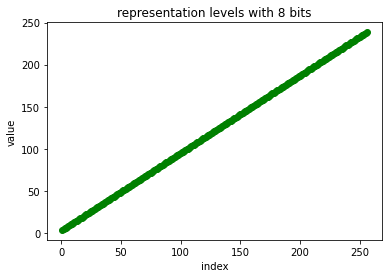

In [ ]:
#question 2,b:
print_uni_rep_des(img_arr)

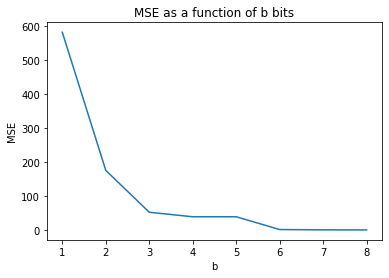

In [ ]:
#Question 4,a:
epsilon=0.001
maxloyd_mse = calc_max_loyd_mse(img,img_arr,epsilon)

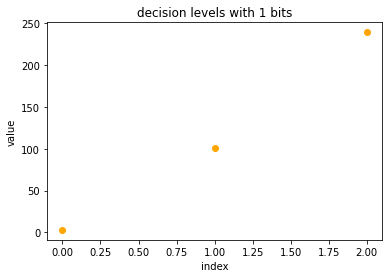

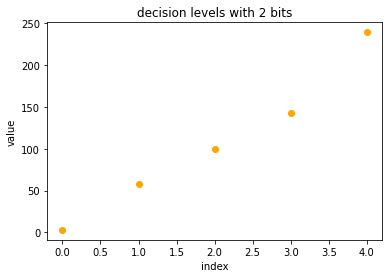

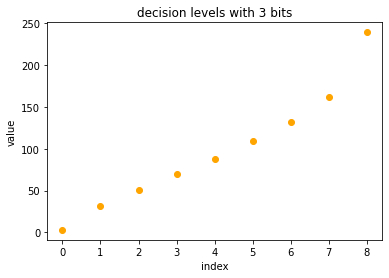

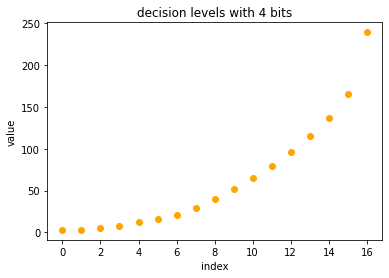

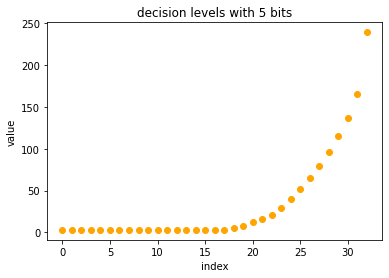

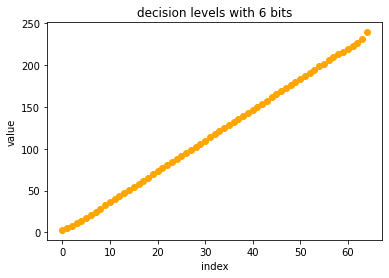

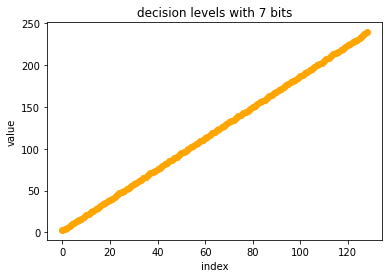

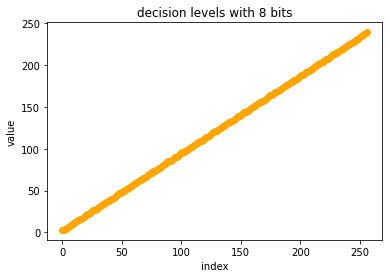

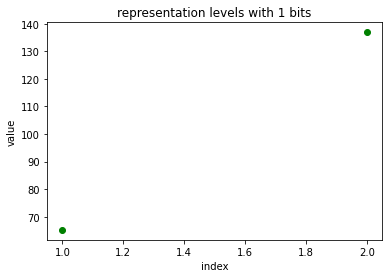

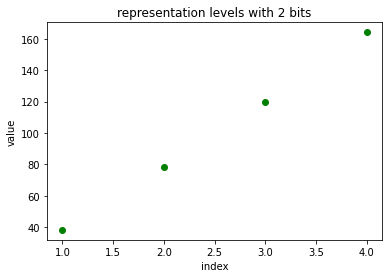

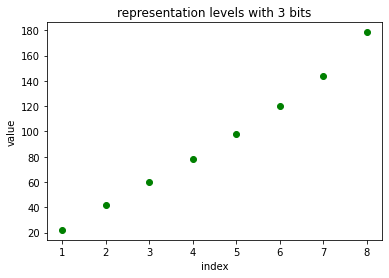

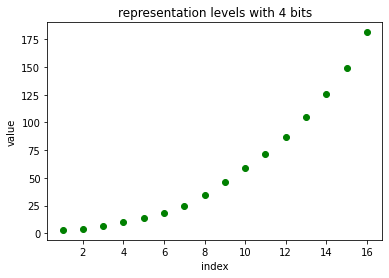

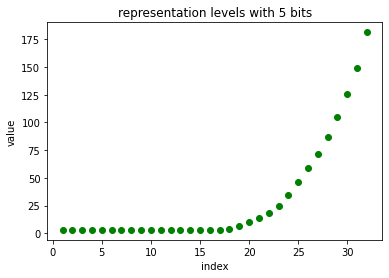

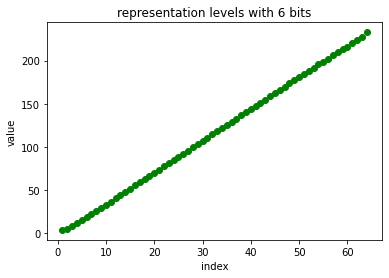

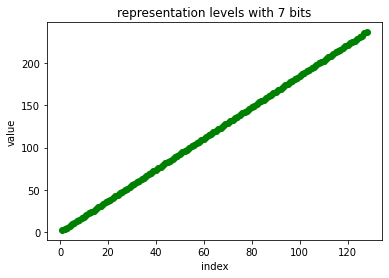

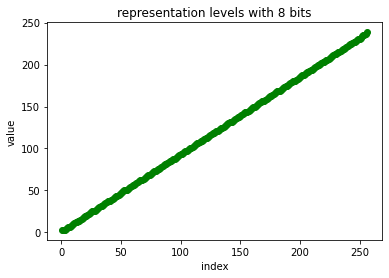

In [ ]:
#Question 4,b:
print_maxloyd_rep_des(img,img_arr,epsilon)

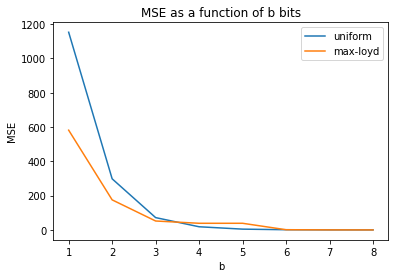

In [ ]:
#Question 4,c:
print_mse_funcs(maxloyd_mse,uni_mse)

Part 3

In [ ]:
#Question 2, implementation of the algorithm from exercise 1.f.
def lp_approx_algorithm(f, N, p, epsilon):
  delta=0.0001
  samples = np.zeros((N,N))
  block_size = f.shape[0]//N
  lp_error_old =  np.mean((f)**p)
  while True:
    error=calc_lp_error(f,samples,block_size,N,p)
    lp_error = error/f.size
    if(np.abs(lp_error - lp_error_old) < delta):
      return samples, lp_error
    lp_error_old = lp_error

In [ ]:
def calc_lp_error(f,samples,block_size,interval,p):
  #according to my answer in dry question 1
  error=0
  for i in range(0 , interval): 
    for j in range(0 , interval): 
      eps=np.array(1/epsilon)
      w_fi_hatfi=(np.abs(f[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size]-samples[i][j]))**(p-2)
      w_prime = np.minimum(eps, w_fi_hatfi)
      fi_next = f[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size]
      if (np.sum(w_prime) != 0) :
        samples[i][j] = np.sum(fi_next*w_prime)/(np.sum(w_prime))
      else:
        samples[i][j] = 0
      error += np.sum((np.abs(f[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size]-samples[i][j]))**p)
  return error

In [ ]:
#question 3, implementing l1 problem solver without using the previous algorithm, 
#we directly use the median when calculating the i-j'th sample.
def calc_exact_l1(img, intervals):
  #same as before but now we specificaly use the median
  samples = np.zeros((intervals,intervals))
  block_size = img.shape[0]//intervals
  error=0
  for i in range(0 , intervals): 
    for j in range(0 , intervals): 
      samples[i][j]=np.median(img[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size])
      error+=np.sum(np.abs(img[i*block_size:(i+1)*block_size,j*block_size:(j+1)*block_size]-samples[i][j]))
  l1_error=error/img.size
  return samples, l1_error

In [ ]:
#we will now compare the exact L1 and the approximation l1
normalized_image=img/255
def comparison_process():
  approx_error=[]
  l1_error_array=[]
  i=0
  for N in np.logspace(0,8, num=6, base=2):
    for epsilon in np.logspace(-3,-7,num=6,base=10):
      sampled_approximation, l1_approximation=lp_approx_algorithm(normalized_image,int(N),1,epsilon)
      approx_error.append(l1_approximation)
      if i%10 == 0:
        #printing choice sampled images
        plt.title("N= " + str(N) + " and epsilon = " + str(epsilon))
        plt.imshow(sampled_approximation, cmap="gray", vmin=0, vmax=1)
        plt.show()
      i+=1
    sampled_image, l1_error=calc_exact_l1(normalized_image,int(N))
    l1_error_array.append(l1_error)
  return approx_error,l1_error_array

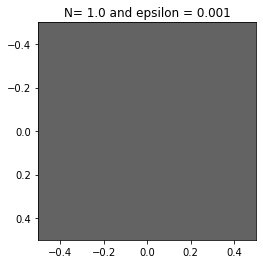

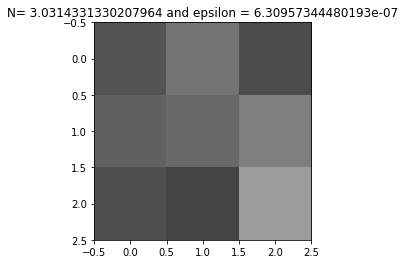

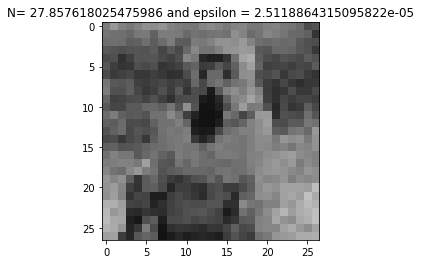

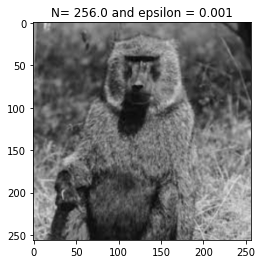

In [ ]:
error_array,l1_error_array=comparison_process()

In [ ]:
print("Printing the approximation l1 errors")
print(error_array[1:7])
print("Printing the exact l1 errors")
print(l1_error_array[1:7])

Printing the approximation l1 errors
[0.1409130744380978, 0.1409130744380978, 0.1409130744380978, 0.1409130744380978, 0.1409130744380978, 0.11059847066890466]
Printing the exact l1 errors
[0.11040843888825062, 0.07833815929936426, 0.05020901549096199, 0.029784812179266276, 0.011810018502026355]


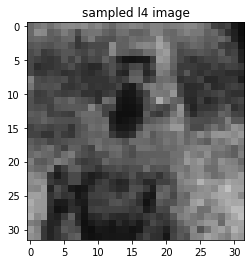

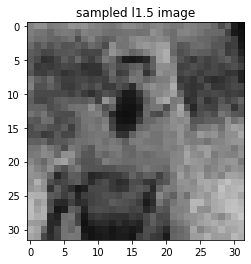

error for l4 approximation is 0.0005163381109501241
error for l1.5 approximation is 0.015713388368610092


In [ ]:
l4_approx, l4_error=lp_approx_algorithm(normalized_image,int(2**5),4,0.001)
l1_5_approx, l1_5_error=lp_approx_algorithm(normalized_image,int(2**5),1.5,0.001)
plt.imshow(l4_approx, cmap="gray", vmin=0, vmax=1)
plt.title("sampled l4 image")
plt.show()
plt.imshow(l1_5_approx, cmap="gray", vmin=0, vmax=1)
plt.title("sampled l1.5 image")
plt.show()

#comparisson for the l4 and l1.5, regarding their errors
print("error for l4 approximation is "+ str(l4_error))
print("error for l1.5 approximation is "+ str(l1_5_error))